### Extract glider section from LLC4320 

In [11]:
import xarray as xr
import numpy as np
from scipy import interpolate
import matplotlib.pyplot as plt

In [2]:
ds = xr.open_dataset('LLC4320_pre-SWOT_ACC_SMST_20111221.nc')

There are two tasks that need to be dealt with here: 
- LLC4320 data does not have lat-lon etc as a coordinate, instead the coordinates are simply index numbers. This means that the lon-lat-depth passed for the trajectory have to be converted to the corresponding index numbers first (which will not be integers). (This is annoying!)
- These interpolated "index numbers" will then be used to extract data on points. 

In [119]:
# Change coordinate of time to make life easier
ds = ds.assign_coords(time=np.linspace(1,24, num=24))

#### Coordinates to "index numbers"


In [6]:
# try for Z first as that 1d. 

z = ds.Z
k = ds.k

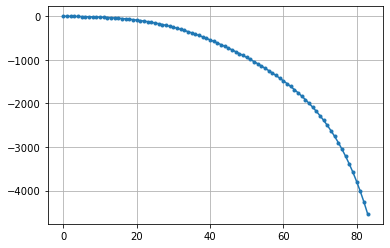

In [16]:
plt.plot(k, z, '.-')
plt.grid()

In [165]:
f_z = interpolate.interp1d(z, k, bounds_error=False)

In [26]:
X = ds.XC
Y = ds.YC

In [36]:
i = ds.i
j = ds.j

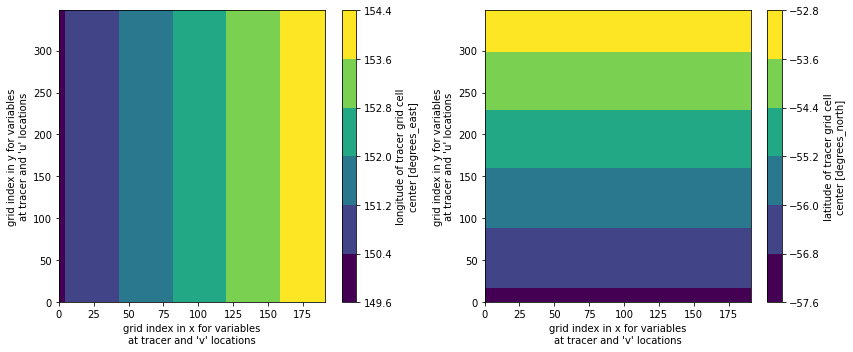

In [30]:
plt.figure(figsize=(12, 5))

plt.subplot(121)
X.plot.contourf()

plt.subplot(122)
Y.plot.contourf()

plt.tight_layout()

It seems like (atleast for this region) the LLC grids are linear, meaning that every i value has only one X associated with. This implies that the grid is not curved relative to i and j. This makes life much easier.

In [38]:
f_x = interpolate.interp1d(X[0,:].values, i)
f_y = interpolate.interp1d(Y[:,0].values, j)

Now that we have the required functions to go from lon, lat, z to the indices i,j,k, we can move forward. 

### Interpolate to the track

In [65]:
print(X.min(), X.max())
print(Y.min(), Y.max())

<xarray.DataArray 'XC' ()>
array(150.30207825) <xarray.DataArray 'XC' ()>
array(154.28125)
<xarray.DataArray 'YC' ()>
array(-56.98995209) <xarray.DataArray 'YC' ()>
array(-53.00566864)


[Text(0, 0.5, 'lat')]

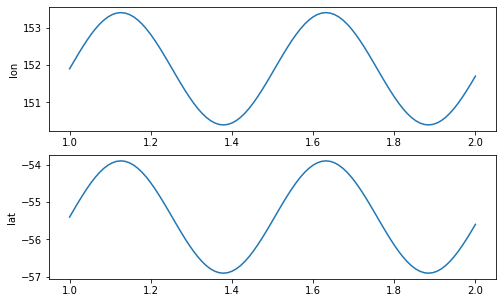

In [122]:
# 150 to 154
# -57 to -53

n = 4*ds.time.size # number of time points
ncycle = 2 # number of crossings
A = 3 # amplitude of the crossings

# create survey data
survey = xr.Dataset(
    dict(
        lon = xr.DataArray(A*(np.sin(2*np.pi*np.arange(n)/(n/ncycle))+1)/2 + 150.4,dims='points'),
        lat = xr.DataArray(A*(np.sin(2*np.pi*np.arange(n)/(n/ncycle))+1)/2 - 56.9,dims='points'),
        time = xr.DataArray(np.linspace(ds.time[0], ds.time[1], num=n),dims='points'),
    )
)

# plot survey lon and lat with time
fig,ax = plt.subplots(2,1,figsize=(8,5))
ax[0].plot(survey.time,survey.lon)
ax[1].plot(survey.time,survey.lat)
ax[0].set(ylabel='lon')
ax[1].set(ylabel='lat')


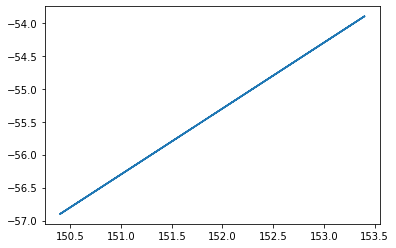

In [123]:
plt.plot(survey.lon, survey.lat)

In [125]:
survey_indices= xr.Dataset(
    dict(
        i = xr.DataArray(f_x(survey.lon), dims='points'),
        j = xr.DataArray(f_y(survey.lat), dims='points'),
        k = xr.DataArray(0*np.zeros_like(survey.lon.data), dims='points'),
        time = xr.DataArray(np.linspace(ds.time[0], ds.time[1], num=n),dims='points'),
    )
)

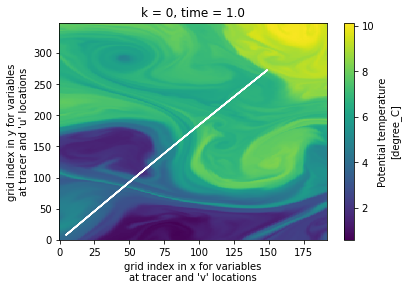

In [127]:
ds.Theta.isel(k=0, time=0).plot()
plt.plot(survey_indices.i, survey_indices.j, color='w')

In [128]:
theta_points = ds.Theta.interp(survey_indices)

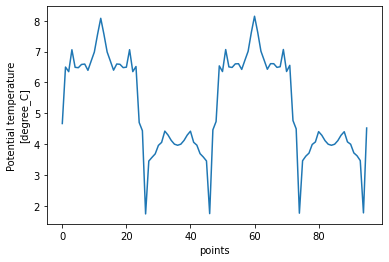

In [129]:
theta_points.plot()

#### Get glider track

In [132]:
import os

In [130]:
data_folder = '../EC2021/submission/data'

In [133]:
ds_CTD_659 = xr.load_dataset(os.path.join(data_folder ,
                                          'sg659', 'CTD_659.nc'))


In [151]:
## Transpose

# Lat
model_boundary_n = ds.YC.max()
model_boundary_s = ds.YC.min()

shifted_lat = (ds_CTD_659.latitude - ds_CTD_659.latitude.min()
              )/(ds_CTD_659.latitude.max() - ds_CTD_659.latitude.min()
                )*(model_boundary_n-model_boundary_s)+ model_boundary_s


# Lon
model_boundary_w = ds.XC.min()
model_boundary_e = ds.XC.max()
shifted_lon = (ds_CTD_659.longitude - ds_CTD_659.longitude.min()
              )/(ds_CTD_659.longitude.max() - ds_CTD_659.longitude.min()
                )*(model_boundary_e-model_boundary_w)+ model_boundary_w



In [169]:

depth = -ds_CTD_659.pressure.where(~np.isnan(ds_CTD_659.pressure), drop=True)
n = len(depth)


survey_track = xr.Dataset(
    dict(
        i = xr.DataArray(f_x(shifted_lon.where(~np.isnan(ds_CTD_659.pressure), drop=True)), dims='points'),
        j = xr.DataArray(f_y(shifted_lat.where(~np.isnan(ds_CTD_659.pressure), drop=True)), dims='points'),
        k = xr.DataArray(f_z(depth), dims='points'),
        time = xr.DataArray(np.linspace(ds.time[0], ds.time[1], num=n),dims='points'),
    )
)

In [175]:
model_points = ds.Theta.interp(survey_track)

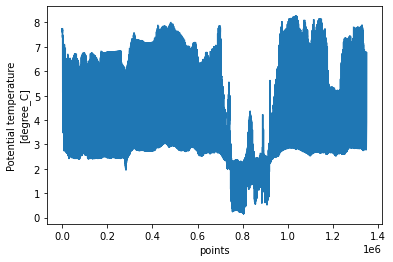

In [181]:
model_points.plot()

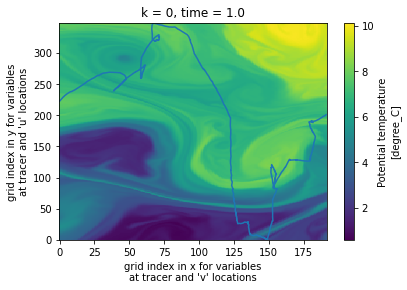

In [156]:
ds.Theta.isel(k=0, time=0).plot()

plt.plot(f_x(shifted_lon), f_y(shifted_lat))

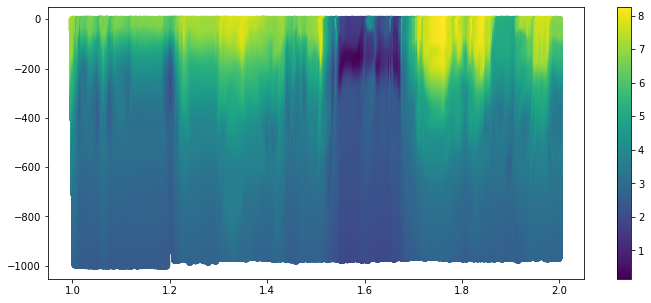

In [182]:
plt.figure(figsize=(12, 5))
plt.scatter(survey_track.time, depth, c=model_points)
plt.colorbar()

### How to work with variables that are not on the i-j grid, but shifted. 

Roughly based on: https://xgcm.readthedocs.io/en/latest/xgcm-examples/02_mitgcm.html

In [185]:
from xgcm import Grid

In [199]:
grid = Grid(ds, coords={'X':{'center': 'i', 'left': 'i_g'}, 
                 'Y':{'center': 'j', 'left': 'j_g'},
                 'Z':{'center': 'k'}})

In [206]:
ds

<xarray.Dataset>
Dimensions:   (j_g: 349, i: 192, i_g: 192, j: 349, k: 84, k_u: 84, k_l: 84, k_p1: 85, nb: 2, time: 24)
Coordinates:
  * j_g       (j_g) float32 0.0 1.0 2.0 3.0 4.0 ... 345.0 346.0 347.0 348.0
  * i         (i) float32 0.0 1.0 2.0 3.0 4.0 ... 187.0 188.0 189.0 190.0 191.0
  * i_g       (i_g) float32 0.0 1.0 2.0 3.0 4.0 ... 188.0 189.0 190.0 191.0
  * j         (j) float32 0.0 1.0 2.0 3.0 4.0 ... 344.0 345.0 346.0 347.0 348.0
  * k         (k) int32 0 1 2 3 4 5 6 7 8 9 10 ... 74 75 76 77 78 79 80 81 82 83
  * k_u       (k_u) int32 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82 83
  * k_l       (k_l) int32 0 1 2 3 4 5 6 7 8 9 ... 74 75 76 77 78 79 80 81 82 83
  * k_p1      (k_p1) int32 0 1 2 3 4 5 6 7 8 9 ... 75 76 77 78 79 80 81 82 83 84
  * nb        (nb) int32 0 1
  * time      (time) float64 1.0 2.0 3.0 4.0 5.0 ... 20.0 21.0 22.0 23.0 24.0
Data variables: (12/35)
    XC        (j, i) float32 150.3 150.3 150.3 150.4 ... 154.2 154.2 154.3 154.3
    YC        (j, i) float32 -56.99 -56.99 -56.99 ... -53.01 -53.01 -53.01
    DXV       (j, i) float32 1.262e+03 1.262e+03 ... 1.394e+03 1.394e+03
    DYU       (j, i) float32 1.231e+03 1.231e+03 ... 1.325e+03 1.325e+03
    Depth     (j, i) float32 3.44e+03 3.463e+03 ... 4.137e+03 4.137e+03
    AngleSN   (j, i) float32 -0.0 6.26e-13 -1.565e-12 ... -0.0 -0.0 -0.0
    ...        ...
    oceTAUY   (time, j_g, i) float64 -0.01227 -0.01241 ... -0.07951 -0.07875
    Theta     (time, k, j, i) float64 3.795 3.782 3.762 3.726 ... nan nan nan
    Salt      (time, k, j, i) float64 33.9 33.9 33.9 33.89 ... nan nan nan nan
    U         (time, k, j, i_g) float32 0.5145 0.5112 0.5072 ... nan nan nan
    V         (time, k, j_g, i) float64 0.3437 0.3822 0.4264 ... nan nan nan
    W         (time, k_l, j, i) float64 -4.397e-05 -4.348e-05 ... nan nan
Attributes: (12/56)
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Dimitris Menemenlis et al.
    contributor:                     Chris Hill, Christopher E. Henze, Jinbo ...
    contributor_role:                MITgcm developer, AMES supercomputer sup...
    cdm_data_type:                   Grid
    Conventions:                     CF-1.7, ACDD-1.3
    ...                              ...
    time_coverage_end:               2011-12-21 23:00:00
    time_coverage_start:             2011-12-21 00:00:00
    title:                           LLC4320 regional Southern Ocean
    geospatial_lon_resolution:       variable
    geospatial_lat_resolution:       variable
    platform:                        MITgcm

In [203]:
U_c = grid.interp(ds.U, 'X', boundary='extend')
V_c = grid.interp(ds.V, 'Y', boundary='extend')

In [207]:
Vort = (grid.diff(ds.V*ds.DXG, 'X') - grid.diff(ds.U*ds.DYG, 'Y'))/ds.RAZ

In [209]:
Vort = grid.interp(grid.interp(Vort, 'X', boundary='extend'), 'Y', boundary='extend')

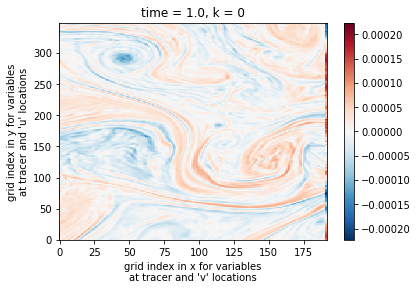

In [220]:
Vort.isel(time=0, k=0).plot()
# there is a little boundary problem in the calculation, but can be dealt with if wanted. 

In [212]:
glider_U = U_c.interp(survey_track)
glider_V = V_c.interp(survey_track)
glider_Vort = Vort.interp(survey_track)

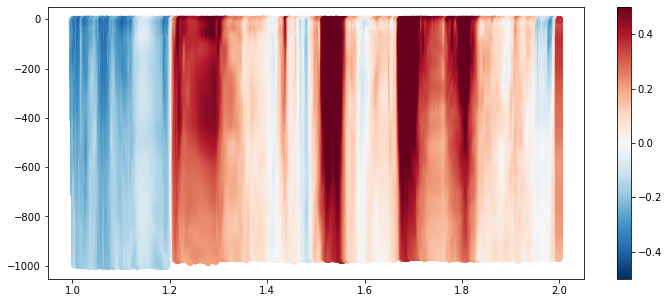

In [217]:
plt.figure(figsize=(12, 5))
plt.scatter(survey_track.time, depth, c=glider_U, vmin=-0.5, vmax=0.5, cmap="RdBu_r")
plt.colorbar()

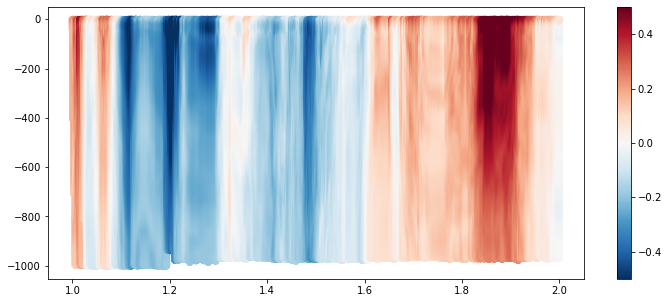

In [218]:
plt.figure(figsize=(12, 5))
plt.scatter(survey_track.time, depth, c=glider_V, vmin=-0.5, vmax=0.5, cmap="RdBu_r")
plt.colorbar()

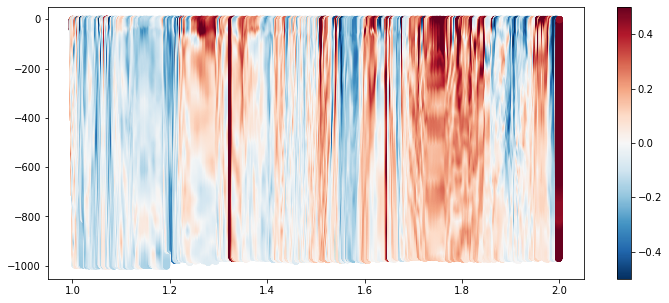

In [216]:
plt.figure(figsize=(12, 5))
plt.scatter(survey_track.time, depth, c=glider_Vort/1e-4, vmin=-0.5, vmax=0.5, cmap='RdBu_r')
plt.colorbar()